In [1]:
%load_ext autoreload
%autoreload 2

from modules import *
from data import *
from training import *
from testing import *

In [ ]:
checkpoint = torch.load('models/model.pth')
model = get_model()#.cuda()
#model.load_state_dict(checkpoint['model'])
losses = checkpoint['losses']

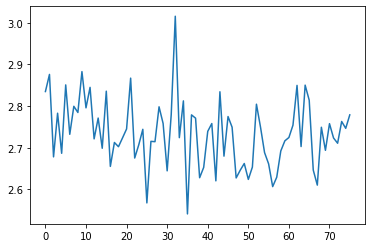

In [3]:
import matplotlib.pyplot as plt
plt.plot(losses[4:])

/home/ericryanchan/environments/cell-instance-segmentation/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


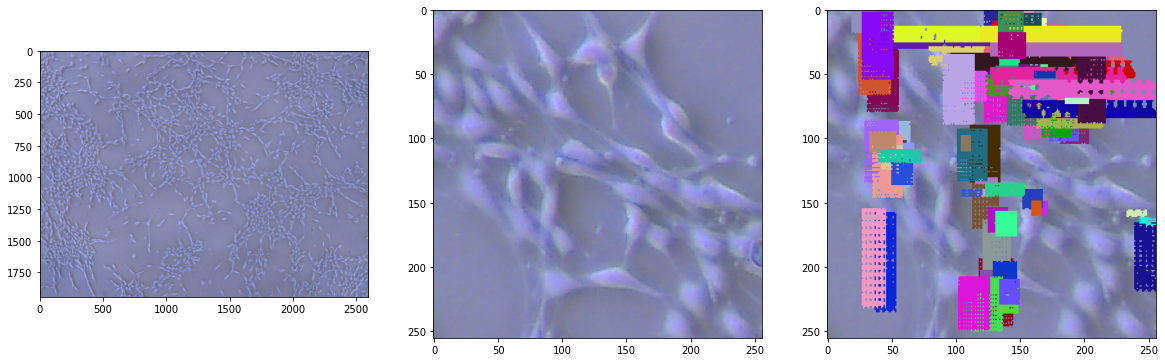

In [4]:
import torchvision.transforms.functional as TF

idx = 3

import json
with open('datasets/export-2020-06-04T19_14_29.068Z.json') as f:
    json_data = json.load(f)
    urls = [obj['Labeled Data'] for obj in json_data]

original_image = get_image_from_url(urls[idx])

i=400
j=100
h=256
w=256
test_image = TF.crop(original_image, i, j, h, w)


test_image.save('in.jpg')
masks, scores = predict_masks(model, test_image)
masks = [m for (m, s) in zip(masks, scores) if s > 0.4]
out_img = composite_masks(test_image, masks)

fig, (axl, axc, axr) = plt.subplots(1, 3, figsize=(20, 40))
axl.imshow(original_image)
axc.imshow(test_image)
axr.imshow(out_img)
out_img.save('out.jpg')

In [10]:
d = CellDataset('datasets/export-2020-06-04T19_14_29.068Z.json')
    
print("Reloading Dataset")
# SELECT ONLY FULLY LABELED
"""
selected_ids = ['MC171178.JPG',
                'MC171181.JPG',
                'MC171179.JPG',
                'MC171177.JPG',
                'MC171180.JPG',
                'image_part_003.jpg',
                'image_part_006.jpg']
"""
selected_ids = ['image_part_003.jpg']
d.data = [img for img in d.data if img['External ID'] in selected_ids]
d.fetch()

Reloading Dataset


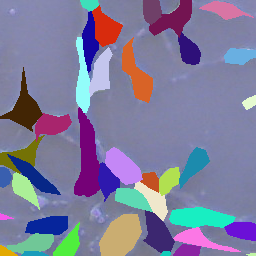

In [13]:
img, target = d[0]
img = Image.fromarray(np.array(img.permute(1, 2, 0).mul(255).byte()))
composite_masks(img, target['masks'][1:])

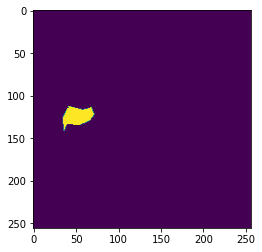

In [13]:
plt.imshow(target['masks'][2])

In [ ]:
print